# Convolutional Neural Networks for Mandarin Tone Classification using Mel-Frequency Cepstral Coefficients

Jeramey Tyler tylerj2@rpi.edu


---



# Introduction

In a tonal language, semantic information is conveyed through the pronunication of the a spoken word. This adds an dimension of complexity to automatic speech recognition tasks (ASR) involving tonal languages. In this notebook I demonstrate classifying Mandarin tones using a convolutional neural network trained on the Mel-frequency cepstral coefficients (MFCC) representation of spoken Mandarin phonemes.

# Data

## Data Loading

The data for this experiment is stored at [this](https://github.com/JerameyATyler/Mandarin_data) GitHub repository. The code below will clone the repository.

In [0]:
!git clone https://github.com/JerameyATyler/Mandarin_data.git

fatal: destination path 'Mandarin_data' already exists and is not an empty directory.


Read data into a Pandas Dataframe.

In [0]:
import pandas as pd

def load_data():
  df = pd.read_pickle('Mandarin_data/mfcc_small.pkl', compression=None)
  
  return df

df = load_data()
df.head(3)

,mfcc,Tone
0,"[[-310.8796789564301, -340.46618065634357, -35...",2.0
1,"[[-266.5372726841016, -259.1848098190291, -264...",1.0
2,"[[-291.45163988780587, -251.88196659859761, -2...",3.0


## Data Representation

In [0]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

Let's see what our data looks like.

In [0]:
def data_peek(x_):
  print('The shape is:', x_.shape)
  print('An element looks like:\n', x_[0].shape)
  
def plot_mfcc(mfcc):
  fig, ax = plt.subplots()
  cax = ax.imshow(mfcc, interpolation='nearest', cmap=cm.coolwarm,
                 origin='lower')
  ax.set_title('MFCC')
  plt.show()

data_peek(df['mfcc'].iloc[0])

The shape is: (40, 4)
An element looks like:
 (4,)


In [0]:
data_peek(df[['Tone']].values)

The shape is: (16026, 1)
An element looks like:
 (1,)


Let's visualize our data.

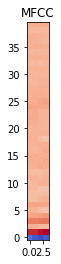

In [0]:
plot_mfcc(df['mfcc'].iloc[0])

# Pre-processing

In [0]:
def preprocess():
  # Load the data into memory
  df = load_data()
  df['mfcc'] = df['mfcc'].apply(lambda i: mp.array(i).reshape(40, -1))
  
  ''' Convert tone categorization to a one-hot categorization '''
  # Subtract 1 so that classification aligns with index
  df['Tone'] = df['Tone'].apply(lambda i: int(i - 1))
  # 
  df['Tone'] = df['Tone'].apply(lambda i: to_categorical(i, num_classes=4))
  

Let's fetch our values

In [0]:
def fetch_xy(df):
  x = np.array([np.array(i[0]).reshape(1, 40, -1) for i in df[['mfcc']].values])
  y = np.array([np.array(i[0]).reshape(4) for i in df[['Tone']].values])
  
  return x, y

We need to reshape the MFCC 

In [0]:
x, y = fetch_xy(df)
x = [i[0].reshape(1, 40, -1) for i in x]

min_size = min([i.shape for i in x])
max_size = max([i.shape for i in x])
print('Min sample size:', min_size)
print('Max sample size:', max_size)

Min sample size: (1,)
Max sample size: (1,)


In [0]:
x = df[['mfcc']].values

data_peek(x)

The shape is: (16026, 1)
An element looks like:
 (1,)


We need the lengths of each MFCC to be the same. This function will pad each until they are all the same size as the largest sample in the dataset.

In [0]:
def pad_mfcc(x_, size):
  result = np.zeros(size)
  result[:x_.shape[0],:x_.shape[1], :x_.shape[2]] = x_
  return result

x = [pad_mfcc(i, max_size) for i in x]
x = np.array(x)

data_peek(x)

The shape is: (16026, 1, 40, 30)
An element looks like:
 (1, 40, 30)


Now let's pre-process our labels. 

In [0]:
from keras.utils import to_categorical

# Subtract 1 so that classification aligns with index
df['Tone'] = df['Tone'].apply(lambda i: int(i - 1))
df['Tone'] = df['Tone'].apply(lambda i: to_categorical(i, num_classes=4))

Using TensorFlow backend.


In [0]:
y = df[['Tone']].values
data_peek(y)

The shape is: (16026, 1)
An element looks like:
 (1,)


In [0]:
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, 
                                                random_state=502)
data_peek(xTrain)
data_peek(yTrain)

The shape is: (12820, 1, 40, 30)
An element looks like:
 (1, 40, 30)
The shape is: (12820, 1)
An element looks like:
 (1,)


In [0]:
from sklearn import preprocessing

X_train = np.array([preprocessing.scale(i.reshape(40, 30)) for i in xTrain])
X_test = np.array([preprocessing.scale(i.reshape(40, 30)) for i in xTest])
data_peek(X_train)

The shape of x is: (12820, 40, 30)
An element in x looks like:
 [[-5.54647868e+00 -5.28417261e+00 -5.27644384e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.82761362e+00  3.26261063e+00  3.25772187e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-6.40913606e-01 -8.00906329e-01 -7.22740026e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 1.18400945e-01  9.49455017e-02  5.61946481e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.08013888e-04  6.53583878e-03  6.60782812e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.37937840e-01  1.17449601e-01  1.18634869e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [0]:
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adadelta
from keras.layers import Dense, Dropout, Activation
from keras.layers import Flatten, Conv2D, MaxPooling2D
from keras.regularizers import l1, l2
import matplotlib.pyplot as plt

In [0]:
def plot_model(history):
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(1, 40, 30..., data_format="channels_first")`
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 10256 samples, validate on 2564 samples
Epoch 1/100
10256/10256 [==============================] - 22s 2ms/step - loss: 1.7779 - acc: 0.3195 - val_loss: 1.3054 - val_acc: 0.4134
Epoch 2/100
10256/10256 [==============================] - 20s 2ms/step - loss: 1.3060 - acc: 0.4151 - val_loss: 1.2402 - val_acc: 0.4879
Epoch 3/100
10256/10256 [==============================] - 20s 2ms/step - loss: 1.2418 - acc: 0.4491 - val_loss: 1.1774 - val_acc: 0.5195
Epoch 4/100
10256/10256 [==============================] - 20s 2ms/step - loss: 1.2106 - acc: 0.4782 - val_loss: 1.1659 - val_acc: 0.5347
Epoch 5/100
10256/10256 [==============================] - 19s 2ms/step - loss: 1.1845 - acc: 0.4894 - val_loss: 1.1099 - val_acc: 0.5589
Epoch 6/100
10256/10256 [==============================] - 19s 2ms/step - loss: 1.1519 - acc: 0.5188 - val_loss: 1.1081 - val_acc: 0.5398
Epoch 7/100
10256/10256 [==============================] - 19s 2ms/step - loss: 1.1336 - acc: 0.5282 - val_loss: 1.1685 - v

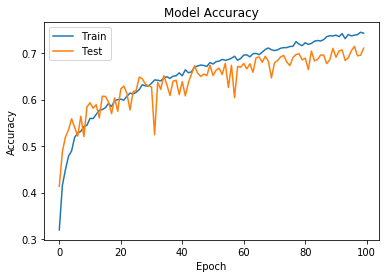

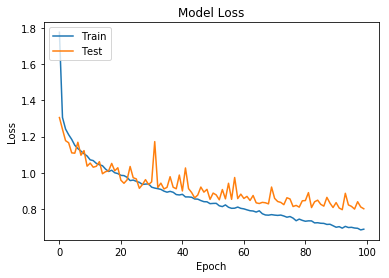

In [0]:
def cnn(x_train, x_test, y_train, y_test):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], dim_ordering='th'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.125))
  
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.125))
  
  model.add(Flatten())
  model.add(Dense(128, activation='relu',
                   kernel_regularizer=l2(0.00001),
                   activity_regularizer=l1(0.00001)))
  model.add(Dropout(0.125))
  model.add(Dense(4, activation='softmax'))
  
  optimizer = SGD(lr=0.01, momentum=1e-2, decay=1e-6)
  # optimizer = RMSprop(lr=0.00001, decay=1e-8)
  # optimizer = Adadelta()

  model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

  model_history = model.fit(x_train, y_train,
           epochs=100,
         batch_size=128, verbose=1, validation_split=0.2)
  score = model.evaluate(x_test, y_test, batch_size=32)
  print('Model accuracy is:', score[1])

  plot_model(model_history)
  return model_history
 
cnn(xTrain, xTest, yTrain, yTest)